In [1]:

#Importing all the relevant library
%matplotlib inline
import h5py, os
#from functions import transforms as T
#from functions.subsample import MaskFunc
from scipy.io import loadmat
from torch.utils.data import DataLoader
import numpy as np
import torch
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
import glob
#from functions import transforms as T 
#from functions.subsample import MaskFunc
from PIL import Image
import random
from numpy.fft import fftshift, ifftshift, fftn, ifftn
import cmath

In [2]:
import torchvision.transforms as transforms

In [3]:
import numpy as np
import torch


class MaskFunc:
    """
    MaskFunc creates a sub-sampling mask of a given shape.

    The mask selects a subset of columns from the input k-space data. If the k-space data has N
    columns, the mask picks out:
        1. N_low_freqs = (N * center_fraction) columns in the center corresponding to
           low-frequencies
        2. The other columns are selected uniformly at random with a probability equal to:
           prob = (N / acceleration - N_low_freqs) / (N - N_low_freqs).
    This ensures that the expected number of columns selected is equal to (N / acceleration)

    It is possible to use multiple center_fractions and accelerations, in which case one possible
    (center_fraction, acceleration) is chosen uniformly at random each time the MaskFunc object is
    called.

    For example, if accelerations = [4, 8] and center_fractions = [0.08, 0.04], then there
    is a 50% probability that 4-fold acceleration with 8% center fraction is selected and a 50%
    probability that 8-fold acceleration with 4% center fraction is selected.
    """

    def __init__(self, center_fractions, accelerations):
        """
        Args:
            center_fractions (List[float]): Fraction of low-frequency columns to be retained.
                If multiple values are provided, then one of these numbers is chosen uniformly
                each time.

            accelerations (List[int]): Amount of under-sampling. This should have the same length
                as center_fractions. If multiple values are provided, then one of these is chosen
                uniformly each time. An acceleration of 4 retains 25% of the columns, but they may
                not be spaced evenly.
        """
        if len(center_fractions) != len(accelerations):
            raise ValueError('Number of center fractions should match number of accelerations')

        self.center_fractions = center_fractions
        self.accelerations = accelerations
        self.rng = np.random.RandomState()

    def __call__(self, shape, seed=None):
        """
        Args:
            shape (iterable[int]): The shape of the mask to be created. The shape should have
                at least 3 dimensions. Samples are drawn along the second last dimension.
            seed (int, optional): Seed for the random number generator. Setting the seed
                ensures the same mask is generated each time for the same shape.
        Returns:
            torch.Tensor: A mask of the specified shape.
        """
        if len(shape) < 3:
            raise ValueError('Shape should have 3 or more dimensions')

        self.rng.seed(seed)
        num_cols = shape[-2]

        choice = self.rng.randint(0, len(self.accelerations))
        center_fraction = self.center_fractions[choice]
        acceleration = self.accelerations[choice]

        # Create the mask
        num_low_freqs = int(round(num_cols * center_fraction))
        prob = (num_cols / acceleration - num_low_freqs) / (num_cols - num_low_freqs)
        mask = self.rng.uniform(size=num_cols) < prob
        pad = (num_cols - num_low_freqs + 1) // 2
        mask[pad:pad + num_low_freqs] = True

        # Reshape the mask
        mask_shape = [1 for _ in shape]
        mask_shape[-2] = num_cols
        mask = torch.from_numpy(mask.reshape(*mask_shape).astype(np.float32))

        return mask



In [4]:
import numpy as np
from numpy.fft import fftshift, ifftshift, fftn, ifftn

def transform_kspace_to_image(k, dim=None, img_shape=None):
    """ Computes the Fourier transform from k-space to image space
    along a given or all dimensions
    :param k: k-space data
    :param dim: vector of dimensions to transform
    :param img_shape: desired shape of output image
    :returns: data in image space (along transformed dimensions)
    """
    if not dim:
        dim = range(k.ndim)

    img = fftshift(ifftn(ifftshift(k, axes=dim), s=img_shape, axes=dim), axes=dim)
    #img = fftshift(ifft2(ifftshift(k, dim=dim)), dim=dim)
    img *= np.sqrt(np.prod(np.take(img.shape, dim)))
    return img


def transform_image_to_kspace(img, dim=None, k_shape=None):
    """ Computes the Fourier transform from image space to k-space space
    along a given or all dimensions
    :param img: image space data
    :param dim: vector of dimensions to transform
    :param k_shape: desired shape of output k-space data
    :returns: data in k-space (along transformed dimensions)
    """
    if not dim:
        dim = range(img.ndim)

    k = fftshift(fftn(ifftshift(img, axes=dim), s=k_shape, axes=dim), axes=dim)
    #k = fftshift(fft2(ifftshift(img, dim=dim)), dim=dim)
    k /= np.sqrt(np.prod(np.take(img.shape, dim)))
    return k

In [5]:

import numpy as np
from PIL import Image
import random
from IPython.display import display


def add_noise(array: np.ndarray, dropout_rate: float = 0.10) -> np.ndarray:
    """
    This function adds noise
    :param array:
    :param dropout_rate: percent of pixels to be dropped
    :return:
    """
   # assert len(array.shape) == 4
   # assert array.shape[1] == 3

    channels = array.shape[1]
    height = array.shape[2]
    width = array.shape[3]

    total_pixels = height * width
    queued_pixels = int(total_pixels * dropout_rate)

    filled_pixels = 0
    while filled_pixels < queued_pixels:
        d_h = random.randint(1, 3)
        d_w = random.randint(1, 3)
        filled_pixels += d_h * d_w
        h = random.randint(0, height - d_h)
        w = random.randint(0, width - d_w)

        # now overwrite selected pixels with random dark color
        array[:, :, h:h+d_h, w:w+d_w] = random.randint(1, 25) / 255.0

    return array


def array_to_image(array: np.ndarray):
    """
    This function converts NumPy array to image
    :param array:
    :return:
    """
    assert len(array.shape) == 4
    assert array.shape[1] == 1 or array.shape[1] == 3

    scaled = (array * 255.0).astype(np.uint8)
    if array.shape[1] == 1:
        reshaped = scaled.reshape((array.shape[2], array.shape[3]))
        return Image.fromarray(reshaped,"L")
    else:
        reshaped = scaled.reshape((3, array.shape[2], array.shape[3])).transpose([1, 2, 0])
        return Image.fromarray(reshaped,"RGB")


def image_to_array(image) -> np.ndarray:
    """
    This function converts image to NumPy array
    :param image:
    :return:
    """
    image1 = np.array(image)
    return np.expand_dims(np.asarray(image1), 0).astype(np.float) / 255.0







In [6]:

def show_slices(data, slice_nums, cmap=None): # visualisation
    fig = plt.figure(figsize=(15,10))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)
        plt.axis('off')

In [7]:
class MRIDataset(DataLoader):
    def __init__(self, data_list):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        subject_id = self.data_list[idx]

        return get_epoch_batch(subject_id)

In [8]:
import random
import numpy as np
from numpy.fft import fftshift, ifftshift, fftn, ifftn
import cmath
def noise_and_kspace(image):
    #change to k-space
    img_fft = fftshift(fftn(image))
    size_img = img_fft.shape
     #np.random.uniform, np.random.normal
    std = np.random.normal(0.000, 0.005) * np.amax(img_fft)
    noise = fftshift(std * np.random.standard_normal(size_img) + std * 1j * np.random.standard_normal(size_img));     #This generates a complex noise signal.
    img_fft_noise = img_fft + noise # k-space
    img_noise = ifftn(ifftshift(img_fft_noise))# revert k-space back to noise
    return img_noise

In [9]:
def get_epoch_batch(subject_id):
    ''' random select a few slices (batch_size) from each volume'''

    fname, rawdata_name = subject_id  
    #get image and get file
    im_frame = Image.open(rawdata_name)
    noise_im_frame = noise_and_kspace(im_frame)

    ############################
    #perform preprocessing
    # resize and tranform to tensor
    preprocess = T.Compose([
                       # T.Grayscale(num_output_channels=1),
                           T.Resize(64),    #128 as maximum #64
                           T.CenterCrop(64),
                           T.ToTensor() #,
                            ])
    img_gt = preprocess(Image.fromarray(np.uint8(im_frame)).convert('L'))
    img_und = preprocess(Image.fromarray(np.uint8(noise_im_frame)).convert('L'))
    #normalize image
    n1 = (img_und**2).sum(dim=-1).sqrt()
    norm = n1.max() 
    if norm < 1e-6: norm = 1e-6
    
    img_gt, img_und = img_gt/norm , img_und/norm

    return img_gt.squeeze(0), img_und.squeeze(0)

In [10]:
def load_data_path(train_data_path, val_data_path):
    """ Go through each subset (training, validation) and list all 
    the file names, the file paths and the slices of subjects in the training and validation sets 
    """

    data_list = {}
    train_and_val = ['train', 'val']
    data_path = [train_data_path, val_data_path]
      
    for i in range(len(data_path)):

        data_list[train_and_val[i]] = []
        
        which_data_path = data_path[i]
        tr = 0
        te = 0
        alfa = 0
    
        for fname in sorted(os.listdir(which_data_path + '/images')):
            if fname == '.DS_Store': continue
            
            subject_data_path = os.path.join(which_data_path + '/images', fname)
                     
            if not os.path.isfile(subject_data_path): continue 
            
     
            #get information from text file
            # this will return a tuple of root and extension
            split_tup = os.path.splitext(fname)

  
            # extract the file name and extension
            file_name = split_tup[0]
  
                
            # the first 5 slices are mostly noise so it is better to exlude them
            data_list[train_and_val[i]].append((fname, subject_data_path))
    
    return data_list

# The initial model, based on the AlexNet architecture

# RestNet

In [11]:
class baseBlock(torch.nn.Module):
    expansion = 1
    def __init__(self,input_planes,planes,stride=1,dim_change=None):
        super(baseBlock,self).__init__()
        #declare convolutional layers with batch norms
        self.conv1 = torch.nn.Conv2d(input_planes,planes,stride=stride,kernel_size=3,padding=1)
        self.bn1   = torch.nn.BatchNorm2d(planes)
        self.conv2 = torch.nn.Conv2d(planes,planes,stride=1,kernel_size=3,padding=1)
        self.bn2   = torch.nn.BatchNorm2d(planes)
        self.dim_change = dim_change
    def forward(self,x):
        #Save the residue
        res = x
        output = F.relu(self.bn1(self.conv1(x)))
        output = self.bn2(self.conv2(output))
        if self.dim_change is not None:
            res = self.dim_change(res)
        
        output += res
        output = F.relu(output)

        return output

class ResNet(torch.nn.Module):
    def __init__(self,block,num_layers,classes=10):
        super(ResNet,self).__init__()
        #according to research paper:
        self.input_planes = 64 #256
        self.conv1 = torch.nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1)
        self.layer1 = self._layer(block,64,num_layers[0],stride=1)
        self.layer2 = self._layer(block,64,num_layers[1],stride=1)
        self.layer3 = self._layer(block,64,num_layers[2],stride=1)
        self.layer4 = self._layer(block,64,num_layers[3],stride=1)
        self.layer5 = self._layer(block,64,num_layers[3],stride=1)
        self.layer6 = self._layer(block,64,num_layers[3],stride=1)
        self.layer7 = self._layer(block,64,num_layers[3],stride=1)
        self.layer8 = self._layer(block,64,num_layers[2],stride=1)
     #   self.layer9 = self._layer(block,64,num_layers[3],stride=1)
      #  self.layer10 = self._layer(block,64,num_layers[3],stride=1)
     #   self.layer11 = self._layer(block,64,num_layers[3],stride=1)
     #   self.layer12 = self._layer(block,64,num_layers[3],stride=1)
      #  self.layer13 = self._layer(block,64,num_layers[3],stride=1)
      #  self.layer14 = self._layer(block,64,num_layers[3],stride=1)
      #  self.layer15 = self._layer(block,64,num_layers[3],stride=1)
      #  self.layer16 = self._layer(block,64,num_layers[3],stride=1)
      #  self.layer17 = self._layer(block,64,num_layers[3],stride=1)
      #  self.layer18 = self._layer(block,64,num_layers[3],stride=1)
        self.conv2 = torch.nn.Conv2d(64,1,kernel_size=3,stride=1, padding=1)
        
    
    def _layer(self,block,planes,num_layers,stride=1):
        dim_change = None
        if stride!=1 or planes != self.input_planes*block.expansion:
            dim_change = torch.nn.Sequential(torch.nn.Conv2d(self.input_planes,planes*block.expansion,kernel_size=1,stride=stride),
                                             torch.nn.BatchNorm2d(planes*block.expansion))
        netLayers =[]
        netLayers.append(block(self.input_planes,planes,stride=stride,dim_change=dim_change))
        self.input_planes = planes * block.expansion
        for i in range(1,num_layers):
            netLayers.append(block(self.input_planes,planes))
            self.input_planes = planes * block.expansion
        
        return torch.nn.Sequential(*netLayers)

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
     #   x = self.layer9(x)
   #     x = self.layer10(x)
     #   x = self.layer11(x)
      #  x = self.layer12(x)
      #  x = self.layer13(x)
     #   x = self.layer14(x)
      #  x = self.layer15(x)
     #   x = self.layer16(x)
     #   x = self.layer17(x)
     #   x = self.layer18(x)
        x = self.conv2(x)

        return x

In [12]:
from skimage.metrics import structural_similarity as cmp_ssim 
from skimage.metrics import mean_squared_error
from skimage.metrics import normalized_root_mse
def ssim(gt, pred):
    """ Compute Structural Similarity Index Metric (SSIM). """
    return cmp_ssim(
         gt, pred, multichannel=False, data_range=gt.max()
    )
#def ssim(gt, pred):
#    """ Compute Structural Similarity Index Metric (SSIM). """
#    return cmp_ssim(
 #       gt.transpose(1, 2, 0), pred.transpose(1, 2, 0), multichannel=True, data_range=gt.max()
 #   )
def mse(gt, pred):
    """ Compute mean squared error. """
    return mean_squared_error(gt, pred)

def nrmse(gt, pred):
    """ Compute normalized root mse. """
    return normalized_root_mse(gt, pred)

In [13]:

    
data_path_train = 'data/train'
data_path_val = 'data/val'
data_list = load_data_path(data_path_train, data_path_val)
    

num_workers = 12 # data loading is faster using a bigger number for num_workers. 0 means using one cpu to load data
    
#mae_loss = nn.L1Loss().to('cuda:0')
mae_loss = nn.L1Loss()
lr = 0.001 # 3e-3
    #acc =8 , network_8fold
network_8fold = ResNet(baseBlock,[2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2])
#network_8fold.to('cuda:0') #move the model on the GPU

    
optimizer2 = optim.Adam(network_8fold.parameters(), lr=lr)

 
train_dataset = MRIDataset(data_list['train'])
val_dataset = MRIDataset(data_list['val'])

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=num_workers) 
print("finish data loading- now train")
 

finish data loading- now train


In [14]:
network_8fold

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer1): Sequential(
    (0): baseBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): baseBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): baseBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): Ba

In [15]:
import time
import random

then = time.time() #Time before the operations start
losses2=[]
mean_loss_list = []
img_nr = 0
epoch_nums = 60 #64 # 5
for epoch in range(epoch_nums):
    for iteration, sample in enumerate(train_loader):
        img_nr += 1
        img_gt, img_und = sample
        
        img_gt = img_gt.unsqueeze(1)#.to('cuda:0') # img_gt = img_gt.unsqueeze(1).to('cuda:0')
        img_und = img_und.unsqueeze(1)#.to('cuda:0') #img_und = img_und.unsqueeze(1).to('cuda:0')
       # img_gt = img_gt.to('cuda:0')
       # img_und = img_und.to('cuda:0')
            
        output = network_8fold(img_und)      #feedforward
        #print(output.shape) #// debug
        loss = mae_loss(output, img_gt)

        optimizer2.zero_grad()       #set current gradients to 0
        loss.backward()      #backpropagate
        optimizer2.step()     #update the weights
        mean_loss_list.append(loss.item())
      #  print("Loss value: ", loss.item())
            #compute and print the mean L1 lossscore for the last 20 training images.
        if img_nr%20 == 0:
            print("L1 Loss score: ", np.round(np.mean(mean_loss_list), decimals = 5), "  Image number: ", img_nr, "  Epoch: ", epoch+1)
            mean_loss_list = []
        losses2.append(loss.item() * img_gt.size(0))
        
now = time.time() #Time after it finished

print("It took: ", now-then, " seconds")

/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.63103   Image number:  20   Epoch:  1
L1 Loss score:  0.06619   Image number:  40   Epoch:  1


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.05085   Image number:  60   Epoch:  2
L1 Loss score:  0.0439   Image number:  80   Epoch:  2


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.03187   Image number:  100   Epoch:  3
L1 Loss score:  0.03015   Image number:  120   Epoch:  3


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.036   Image number:  140   Epoch:  4
L1 Loss score:  0.03531   Image number:  160   Epoch:  4


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.03431   Image number:  180   Epoch:  5
L1 Loss score:  0.02963   Image number:  200   Epoch:  5
L1 Loss score:  0.02865   Image number:  220   Epoch:  5


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.02499   Image number:  240   Epoch:  6
L1 Loss score:  0.03319   Image number:  260   Epoch:  6


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.02635   Image number:  280   Epoch:  7
L1 Loss score:  0.03647   Image number:  300   Epoch:  7


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.03239   Image number:  320   Epoch:  8
L1 Loss score:  0.02255   Image number:  340   Epoch:  8


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.01952   Image number:  360   Epoch:  9
L1 Loss score:  0.01889   Image number:  380   Epoch:  9


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.01777   Image number:  400   Epoch:  10
L1 Loss score:  0.01567   Image number:  420   Epoch:  10
L1 Loss score:  0.02001   Image number:  440   Epoch:  10


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.02157   Image number:  460   Epoch:  11
L1 Loss score:  0.01196   Image number:  480   Epoch:  11


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.01979   Image number:  500   Epoch:  12
L1 Loss score:  0.01705   Image number:  520   Epoch:  12


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.01079   Image number:  540   Epoch:  13
L1 Loss score:  0.01292   Image number:  560   Epoch:  13


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00864   Image number:  580   Epoch:  14
L1 Loss score:  0.01263   Image number:  600   Epoch:  14


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00856   Image number:  620   Epoch:  15
L1 Loss score:  0.00651   Image number:  640   Epoch:  15
L1 Loss score:  0.0067   Image number:  660   Epoch:  15


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00661   Image number:  680   Epoch:  16
L1 Loss score:  0.00819   Image number:  700   Epoch:  16


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00691   Image number:  720   Epoch:  17
L1 Loss score:  0.00696   Image number:  740   Epoch:  17


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00643   Image number:  760   Epoch:  18
L1 Loss score:  0.00597   Image number:  780   Epoch:  18


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00657   Image number:  800   Epoch:  19
L1 Loss score:  0.00751   Image number:  820   Epoch:  19


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00619   Image number:  840   Epoch:  20
L1 Loss score:  0.00721   Image number:  860   Epoch:  20
L1 Loss score:  0.00544   Image number:  880   Epoch:  20


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00489   Image number:  900   Epoch:  21
L1 Loss score:  0.00607   Image number:  920   Epoch:  21


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00549   Image number:  940   Epoch:  22
L1 Loss score:  0.00469   Image number:  960   Epoch:  22


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00428   Image number:  980   Epoch:  23
L1 Loss score:  0.00421   Image number:  1000   Epoch:  23


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00441   Image number:  1020   Epoch:  24
L1 Loss score:  0.00399   Image number:  1040   Epoch:  24


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00488   Image number:  1060   Epoch:  25
L1 Loss score:  0.00329   Image number:  1080   Epoch:  25
L1 Loss score:  0.0042   Image number:  1100   Epoch:  25


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00456   Image number:  1120   Epoch:  26
L1 Loss score:  0.00538   Image number:  1140   Epoch:  26


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00364   Image number:  1160   Epoch:  27
L1 Loss score:  0.00456   Image number:  1180   Epoch:  27


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00495   Image number:  1200   Epoch:  28
L1 Loss score:  0.0036   Image number:  1220   Epoch:  28


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00342   Image number:  1240   Epoch:  29
L1 Loss score:  0.00371   Image number:  1260   Epoch:  29


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00637   Image number:  1280   Epoch:  30
L1 Loss score:  0.00484   Image number:  1300   Epoch:  30
L1 Loss score:  0.00401   Image number:  1320   Epoch:  30


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00459   Image number:  1340   Epoch:  31
L1 Loss score:  0.00459   Image number:  1360   Epoch:  31


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00481   Image number:  1380   Epoch:  32
L1 Loss score:  0.00412   Image number:  1400   Epoch:  32


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00473   Image number:  1420   Epoch:  33
L1 Loss score:  0.00509   Image number:  1440   Epoch:  33


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00407   Image number:  1460   Epoch:  34
L1 Loss score:  0.00374   Image number:  1480   Epoch:  34


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00429   Image number:  1500   Epoch:  35
L1 Loss score:  0.00347   Image number:  1520   Epoch:  35
L1 Loss score:  0.00307   Image number:  1540   Epoch:  35


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00278   Image number:  1560   Epoch:  36
L1 Loss score:  0.00398   Image number:  1580   Epoch:  36


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00538   Image number:  1600   Epoch:  37
L1 Loss score:  0.00427   Image number:  1620   Epoch:  37


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00468   Image number:  1640   Epoch:  38
L1 Loss score:  0.00372   Image number:  1660   Epoch:  38


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00521   Image number:  1680   Epoch:  39
L1 Loss score:  0.0037   Image number:  1700   Epoch:  39


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00261   Image number:  1720   Epoch:  40
L1 Loss score:  0.0029   Image number:  1740   Epoch:  40
L1 Loss score:  0.00304   Image number:  1760   Epoch:  40


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00452   Image number:  1780   Epoch:  41
L1 Loss score:  0.00384   Image number:  1800   Epoch:  41


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00285   Image number:  1820   Epoch:  42
L1 Loss score:  0.00271   Image number:  1840   Epoch:  42


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00375   Image number:  1860   Epoch:  43
L1 Loss score:  0.00273   Image number:  1880   Epoch:  43


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00379   Image number:  1900   Epoch:  44
L1 Loss score:  0.00331   Image number:  1920   Epoch:  44


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00303   Image number:  1940   Epoch:  45
L1 Loss score:  0.00294   Image number:  1960   Epoch:  45
L1 Loss score:  0.00363   Image number:  1980   Epoch:  45


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00349   Image number:  2000   Epoch:  46
L1 Loss score:  0.00277   Image number:  2020   Epoch:  46


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.0028   Image number:  2040   Epoch:  47
L1 Loss score:  0.00277   Image number:  2060   Epoch:  47


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00343   Image number:  2080   Epoch:  48
L1 Loss score:  0.00325   Image number:  2100   Epoch:  48


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00333   Image number:  2120   Epoch:  49
L1 Loss score:  0.00314   Image number:  2140   Epoch:  49


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00279   Image number:  2160   Epoch:  50
L1 Loss score:  0.00287   Image number:  2180   Epoch:  50
L1 Loss score:  0.00245   Image number:  2200   Epoch:  50


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00303   Image number:  2220   Epoch:  51
L1 Loss score:  0.00307   Image number:  2240   Epoch:  51


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.0035   Image number:  2260   Epoch:  52
L1 Loss score:  0.00402   Image number:  2280   Epoch:  52


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00368   Image number:  2300   Epoch:  53
L1 Loss score:  0.00491   Image number:  2320   Epoch:  53


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00409   Image number:  2340   Epoch:  54
L1 Loss score:  0.00354   Image number:  2360   Epoch:  54


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00419   Image number:  2380   Epoch:  55
L1 Loss score:  0.0036   Image number:  2400   Epoch:  55
L1 Loss score:  0.00339   Image number:  2420   Epoch:  55


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00288   Image number:  2440   Epoch:  56
L1 Loss score:  0.00262   Image number:  2460   Epoch:  56


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00344   Image number:  2480   Epoch:  57
L1 Loss score:  0.00307   Image number:  2500   Epoch:  57


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00294   Image number:  2520   Epoch:  58
L1 Loss score:  0.00265   Image number:  2540   Epoch:  58


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00241   Image number:  2560   Epoch:  59
L1 Loss score:  0.00279   Image number:  2580   Epoch:  59


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex

L1 Loss score:  0.00365   Image number:  2600   Epoch:  60
L1 Loss score:  0.00316   Image number:  2620   Epoch:  60
L1 Loss score:  0.00281   Image number:  2640   Epoch:  60
It took:  98824.52507400513  seconds


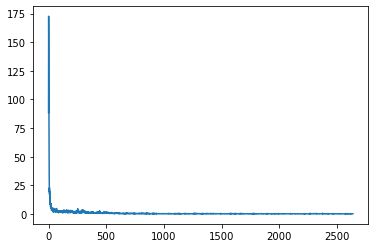

In [16]:
plt.plot(losses2)
plt.show()

In [17]:
#compute the SSIM score for every image after a feedforward propagation through 
#the network.
#Subtract the image SSIM score before the feedforward prop to obtain the net improvement for every image.
#Print the average improvement and the average SSIM score after the reconstruction.
SSIM_improvement = []
SSIM_score = []
MSE_improvement = []
MSE_score = []
NRMSE_improvement = []
NRMSE_score = []
MIE_improvement = []
MIE_score = []
for i in range(0,len(val_dataset)):
    gt, image = val_dataset[i]
    #image = image.unsqueeze(0).to('cuda:0')
    image = image.unsqueeze(0)
    image = image.unsqueeze(0)
    gt = gt.unsqueeze(0).numpy()
    output = network_8fold(image)
  #  output = output.squeeze(1).cpu().detach().numpy()
    output = output.squeeze(1).detach().numpy()
    image = image.squeeze(1).numpy()
    gt =  np.squeeze(gt)
    output =  np.squeeze(output)
    image =  np.squeeze(image)


    output_loss1 = torch.tensor(ssim(gt, output))
    output_loss2 = torch.tensor(mse(gt, output))
    output_loss3 = torch.tensor(nrmse(gt, output))
    output_loss4 = np.mean(np.abs(gt - output))
  #  image_loss = torch.tensor(ssim(gt, image.squeeze(1).cpu().numpy()))
    image_loss1 = torch.tensor(ssim(gt, image))
    image_loss2 = torch.tensor(mse(gt, image))
    image_loss3 = torch.tensor(nrmse(gt, image))
    image_loss4 = np.mean(np.abs(gt - image))
    SSIM_improvement.append(output_loss1.item()-image_loss1.item())
    SSIM_score.append(output_loss1.item())
    MSE_improvement.append(output_loss2.item()-image_loss2.item())
    MSE_score.append(output_loss2.item())
    NRMSE_improvement.append(output_loss3.item()-image_loss3.item())
    NRMSE_score.append(output_loss3.item())
    MIE_improvement.append(output_loss4 -image_loss4)
    MIE_score.append(output_loss4)

print(np.nanmean(SSIM_improvement))
print(np.nanmean(SSIM_score))
print(np.nanmean(MSE_improvement))
print(np.nanmean(MSE_score))
print(np.nanmean(NRMSE_improvement))
print(np.nanmean(NRMSE_score))
print(np.nanmean(MIE_improvement))
print(np.nanmean(MIE_score))

/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part


-0.2611633710568649
0.015875371566549102
0.016950985397322427
0.023213561269686926
2.190573696613077
5.670670496565955
0.03825166
0.08903692


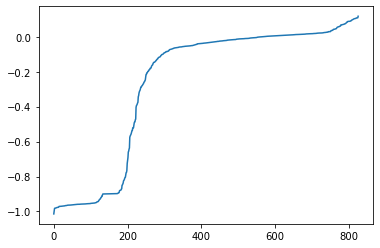

In [18]:
SSIM_improvement.sort()
plt.plot(SSIM_improvement)

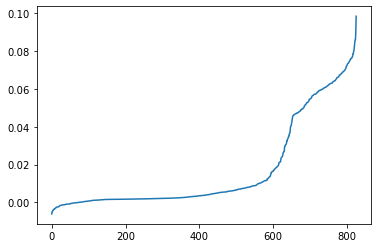

In [19]:
MSE_improvement.sort()
plt.plot(MSE_improvement)

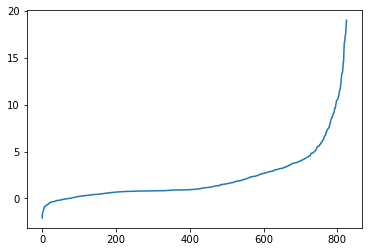

In [20]:
NRMSE_improvement.sort()
plt.plot(NRMSE_improvement)

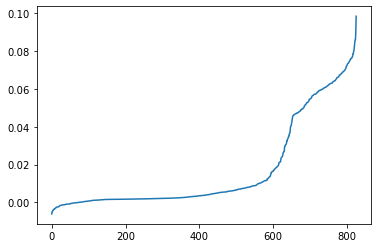

In [21]:
MIE_improvement.sort()
plt.plot(MSE_improvement)

## save Model

In [22]:
index = 10

In [23]:
#output_dir = f"s3://savemodels/network_8fold/restnet-model{index}.pt"
output_dir = f"./network_8fold/restnet-model{index}.pt"

In [24]:
#save model to S3 bucket or data
torch.save(network_8fold.state_dict(), output_dir)
#torch.save(network_8fold.state_dict(), './models/resnet18-model.pt')

## Load Model from saved model

In [ ]:
index = 10

In [ ]:
#output_dir = f"s3://savemodels/network_8fold/restnet-model{index}.pt"
output_dir = f"./network_8fold/restnet-model{index}.pt"

In [ ]:
#load model on CPU: laptop
device = torch.device('cpu')
#model = TheModelClass(*args, **kwargs)
model = ResNet(baseBlock,[2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2])
#model.load_state_dict(torch.load(PATH, map_location=device))
model.load_state_dict(torch.load(output_dir, map_location=device))
model.eval()

## Predict a single image

In [25]:
index = 10

In [26]:
#model_dir = f"s3://savemodels/network_8fold/restnet-model{index}.pt"
model_dir = f"./network_8fold/restnet-model{index}.pt"

In [27]:
#load model on CPU: laptop
device = torch.device('cpu')
#model = TheModelClass(*args, **kwargs)
model = ResNet(baseBlock,[2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2])
#model.load_state_dict(torch.load(PATH, map_location=device))
model.load_state_dict(torch.load(model_dir, map_location=device))
model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer1): Sequential(
    (0): baseBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): baseBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): baseBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): Ba

In [28]:
#compute the SSIM score for every image after a feedforward propagation through 
#the network.
#Subtract the image SSIM score before the feedforward prop to obtain the net improvement for every image.
#Print the average improvement and the average SSIM score after the reconstruction.
SSIM_improvement = []
SSIM_score = []
MSE_improvement = []
MSE_score = []
MIE_improvement = []
MIE_score = []
for i in range(0,len(train_dataset)):
    gt, image = train_dataset[i]
    #image = image.unsqueeze(0).to('cuda:0')
    image = image.unsqueeze(0)
    image = image.unsqueeze(0)
    gt = gt.unsqueeze(0).numpy()
    output = model(image)
  #  output = output.squeeze(1).cpu().detach().numpy()
    output = output.squeeze(1).detach().numpy()
    image = image.squeeze(1).numpy()
    gt =  np.squeeze(gt)
    output =  np.squeeze(output)
    image =  np.squeeze(image)


    output_loss1 = torch.tensor(ssim(gt, output))
    output_loss2 = torch.tensor(mse(gt, output))
    output_loss3 = np.mean(np.abs(gt - output))
  #  image_loss = torch.tensor(ssim(gt, image.squeeze(1).cpu().numpy()))
    image_loss1 = torch.tensor(ssim(gt, image))
    image_loss2 = torch.tensor(mse(gt, image))
    image_loss3 = np.mean(np.abs(gt - image))
    SSIM_improvement.append(output_loss1.item()-image_loss1.item())
    SSIM_score.append(output_loss1.item())
    MSE_improvement.append(output_loss2.item()-image_loss2.item())
    MSE_score.append(output_loss2.item())
    MIE_improvement.append(output_loss3 -image_loss3)
    MIE_score.append(output_loss3)

print(np.nanmean(SSIM_improvement))
print(np.nanmean(SSIM_score))
print(np.nanmean(MSE_improvement))
print(np.nanmean(MSE_score))
print(np.nanmean(MIE_improvement))
print(np.nanmean(MIE_score))

/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part


-0.24742434310616143
0.0007427457011952382
12.341717756426904
12.348182509421859
0.102100186
0.15415692


In [ ]:
SSIM_improvement.sort()
plt.plot(SSIM_improvement)

In [ ]:
MSE_improvement.sort()
plt.plot(MSE_improvement)

In [ ]:
MIE_improvement.sort()
plt.plot(MSE_improvement)

In [ ]:
from PIL import Image

In [30]:
file_dir = "data/test/images/244.png"

In [31]:
im_frame = Image.open(file_dir)
   
noise_im_frame = noise_and_kspace(im_frame)

preprocess = T.Compose([
                       # T.Grayscale(num_output_channels=1),
                           T.Resize(64),    #128 as maximum
                           T.CenterCrop(64),
                           T.ToTensor() #,
                           #T.Normalize(
                            #        mean=[0.485, 0.456, 0.406],
                               #        std=[0.229, 0.224, 0.225]
                             ##         )
                            ])
img_gt = preprocess(Image.fromarray(np.uint8(im_frame)).convert('L'))
img_und = preprocess(Image.fromarray(np.uint8(noise_im_frame)).convert('L'))
    
n1 = (img_und**2).sum(dim=-1).sqrt()
norm = n1.max() 
if norm < 1e-6: norm = 1e-6
    
img_gt, img_und = img_gt/norm , img_und/norm  
    




/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


In [ ]:
from skimage.metrics import structural_similarity as cmp_ssim 
def ssim(gt, pred):
    """ Compute Structural Similarity Index Metric (SSIM). """
    return cmp_ssim(
        gt, pred, multichannel=True, data_range=gt.max()
    )

In [32]:
    #noise_image = noise_image.to('cuda:0')
#img_gt = img_gt.numpy()
img_und = img_und.unsqueeze(0)
output = model(img_und)
   # output = output.squeeze(1).cpu().detach().numpy()
output = output.squeeze(1).detach() #.numpy()   #image under numpy form
#output_loss = torch.tensor(ssim(img_gt, output))  
#image_loss = torch.tensor(ssim(img_gt, img_noise.squeeze(1).numpy()))
#SSIM_improvement = (output_loss.item()-image_loss.item())
#SSIM_score = output_loss.item()

In [33]:
output.shape

torch.Size([1, 64, 64])

In [34]:
np_rescontruct_image =  output # np.reshape(output, (64, 64))# image noise numpy array
im_reconstruct = T.ToPILImage()(np_rescontruct_image)#Image.fromarray(np_rescontruct_image).convert('L')
im_reconstruct.save("testing/test.png") #for prediction values
im_reconstruct.save("pred1.png")

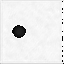

In [35]:
display(im_reconstruct)

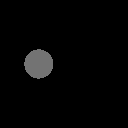

In [36]:
display(im_frame)

In [37]:
display(noise_im_frame )

array([[ -7.21511676 +9.08613818j,   1.36610247 +7.09533278j,
         -0.39185446 +1.70348804j, ...,  -5.05650907 -1.80989693j,
          1.85131416 -4.78494871j,  -2.62369527 -6.90081411j],
       [-16.63741601 +2.18158112j,   2.61718711 -5.5495199j ,
          5.58478273 +7.08333205j, ...,   3.99448481 +1.78521228j,
          1.30389772 -2.07651072j,  -7.89954822 +5.02978877j],
       [ -1.49093246 -8.37431271j,  -3.04625259 -6.6053945j ,
         -9.47937495 -0.28886342j, ...,  -0.42788092 +8.1625706j ,
          3.84761727 +4.68151249j,  -1.43794049+10.1262408j ],
       ...,
       [  4.61153095 +1.31918347j,   3.52389396 -2.39816819j,
          5.76796891 -4.60300125j, ...,  15.79847835+16.98790547j,
         -4.35836413 -3.65752454j,  -3.56631917 +8.40428942j],
       [ -5.84866809 -4.37163977j,  -7.83523825 +1.63239353j,
         -0.41969088 +0.55603787j, ...,  -2.00939858 -0.2321897j ,
          8.52311736 +4.86869634j,  -3.3658144  -3.09437697j],
       [  0.35400659 +0.9869